In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display

from tqdm import tqdm

plt.style.use("dark_background")


## The Finite Volume Method in CFD video series

https://youtube.com/playlist?list=PLnJ8lIgfDbkp5DtCPtP2rcqEEUJk-PM8N&si=NvpF64pgI-nEt85i

### Classes

#### Node, Face, Cell classes


In [45]:
class Node:
    def __init__(self, id, coordinates):
        """
        Initialize a node.
        :param id: Global ID for the node.
        :param coordinates: Tuple of coordinates (x, y, z).
        """
        self.id = id
        self.coordinates = coordinates
        self.neighbors = []  # List of neighboring node IDs

    def add_neighbor(self, neighbor_id):
        self.neighbors.append(neighbor_id)

    def __repr__(self):
        return f"Node(id={self.id}, coordinates={self.coordinates}, neighbors={self.neighbors})"


class Face:
    def __init__(self, id, nodes):
        """
        Initialize a face.
        :param id: Global ID for the face.
        :param nodes: List of node IDs defining the face.
        """
        self.id = id
        self.nodes = nodes  # Nodes that make up the face
        self.neighbor_cells = []  # IDs of adjacent cells

    def add_neighbor_cell(self, cell_id):
        self.neighbor_cells.append(cell_id)

    def __repr__(self):
        return f"Face(id={self.id}, nodes={self.nodes}, neighbor_cells={self.neighbor_cells})"


class Cell:
    def __init__(self, id, nodes, faces):
        """
        Initialize a cell.
        :param id: Global ID for the cell.
        :param nodes: List of node IDs defining the cell.
        :param faces: List of face IDs defining the cell.
        """
        self.id = id
        self.nodes = nodes  # Nodes that make up the cell
        self.faces = faces  # Faces that bound the cell
        self.neighbor_cells = []  # IDs of adjacent cells

    def add_neighbor_cell(self, neighbor_id):
        self.neighbor_cells.append(neighbor_id)

    def __repr__(self):
        return (f"Cell(id={self.id}, nodes={self.nodes}, faces={self.faces}, "
                f"neighbor_cells={self.neighbor_cells})")


# Example usage
node1 = Node(1, (0.0, 0.0, 0.0))
node2 = Node(2, (1.0, 0.0, 0.0))
node3 = Node(3, (1.0, 1.0, 0.0))

face1 = Face(1, [1, 2])
face2 = Face(2, [2, 3])

cell1 = Cell(1, [1, 2, 3], [1, 2])

cell1.add_neighbor_cell(2)  # Cell 2 is a neighbor
face1.add_neighbor_cell(1)  # Cell 1 is adjacent to face 1
node1.add_neighbor(2)       # Node 2 is a neighbor of Node 1

#### Mesh class

In [43]:
class Mesh:
    def __init__(self, nodes, faces, cells):
        """
        Initialize an empty Mesh object with lists to store nodes, faces, and cells.
        """
        self.nodes = nodes
        self.faces = faces
        self.cells = cells

    def add_node(self, node):
        """
        Add a Node to the mesh.
        :param node: Node object to add.
        """
        self.nodes.append(node)

    def add_face(self, face):
        """
        Add a Face to the mesh.
        :param face: Face object to add.
        """
        self.faces.append(face)

    def add_cell(self, cell):
        """
        Add a Cell to the mesh.
        :param cell: Cell object to add.
        """
        self.cells.append(cell)

    def get_node(self, node_id):
        """
        Retrieve a Node by its ID.
        :param node_id: ID of the Node to retrieve.
        :return: Node object.
        """
        return next(node for node in self.nodes if node.id == node_id)

    def get_face(self, face_id):
        """
        Retrieve a Face by its ID.
        :param face_id: ID of the Face to retrieve.
        :return: Face object.
        """
        return next(face for face in self.faces if face.id == face_id)

    def get_cell(self, cell_id):
        """
        Retrieve a Cell by its ID.
        :param cell_id: ID of the Cell to retrieve.
        :return: Cell object.
        """
        return next(cell for cell in self.cells if cell.id == cell_id)

    def __repr__(self):
        """
        Return a string representation of the Mesh object.
        """
        return (f"Mesh(\n"
                f"  Nodes: {len(self.nodes)},\n"
                f"  Faces: {len(self.faces)},\n"
                f"  Cells: {len(self.cells)}\n)")

    def print_detailed_info(self):
        """
        Print detailed information about the mesh, including nodes, faces, and cells.
        """

        print("Nodes:")
        for node in self.nodes:
            print(node)
        print("Faces:")
        for face in self.faces:
            print(face)
        print("Cells:")
        for cell in self.cells:
            print(cell)

    def plot(self):
        """
        Plot the mesh using the plot_system function.
        """
        plot_system(self.nodes, self.faces, self.cells)


### Utils

#### Creating mesh for choosen system of geometry

In [ ]:
def create_2d_rectangular_mesh(system_size, num_cells):
    """
    Create a 2D rectangular mesh with the given system size and number of cells.
    :param system_size: Tuple (width, height) of the system.
    :param num_cells: Tuple (nx, ny) with the number of cells in the x and y directions.
    :return: Lists of nodes, faces, and cells.
    """
    width, height = system_size
    nx, ny = num_cells

    # Generate nodes
    dx = width / nx
    dy = height / ny
    nodes = []
    node_id = 0
    node_map = {}  # Maps (i, j) to node ID
    for j in range(ny + 1):
        for i in range(nx + 1):
            x = i * dx
            y = j * dy
            nodes.append(Node(node_id, (x, y)))
            node_map[(i, j)] = node_id
            node_id += 1

    # Generate faces
    faces = []
    face_id = 0
    face_map = {}  # To ensure unique face IDs
    for j in range(ny):
        for i in range(nx):
            # Vertical face (left)
            left_face_nodes = [node_map[(i, j)], node_map[(i, j + 1)]]
            if tuple(left_face_nodes) not in face_map:
                faces.append(Face(face_id, left_face_nodes))
                face_map[tuple(left_face_nodes)] = face_id
                face_id += 1

            # Horizontal face (bottom)
            bottom_face_nodes = [node_map[(i, j)], node_map[(i + 1, j)]]
            if tuple(bottom_face_nodes) not in face_map:
                faces.append(Face(face_id, bottom_face_nodes))
                face_map[tuple(bottom_face_nodes)] = face_id
                face_id += 1

            if i == nx - 1:
                right_face_nodes = [node_map[(i + 1, j)], node_map[(i + 1, j + 1)]]
                faces.append(Face(face_id, right_face_nodes))
                face_map[tuple(sorted(right_face_nodes))] = face_id
                face_id += 1

            if j == ny - 1:
                top_face_nodes = [node_map[(i, j + 1)], node_map[(i + 1, j + 1)]]
                faces.append(Face(face_id, top_face_nodes))
                face_map[tuple(sorted(top_face_nodes))] = face_id
                face_id += 1


    # Generate cells
    cells = []
    cell_id = 0
    for j in range(ny):
        for i in range(nx):
            cell_nodes = [
                node_map[(i, j)],
                node_map[(i + 1, j)],
                node_map[(i + 1, j + 1)],
                node_map[(i, j + 1)],
            ]
            cell_faces = [
                face_map[tuple(sorted([node_map[(i, j)], node_map[(i, j + 1)]]))],  # Left
                face_map[tuple(sorted([node_map[(i, j)], node_map[(i + 1, j)]]))],  # Bottom
                face_map[tuple(sorted([node_map[(i + 1, j)], node_map[(i + 1, j + 1)]]))],  # Right
                face_map[tuple(sorted([node_map[(i, j + 1)], node_map[(i + 1, j + 1)]]))],  # Top
            ]
            cells.append(Cell(cell_id, cell_nodes, cell_faces))
            cell_id += 1

    return nodes, faces, cells


#### Plotting

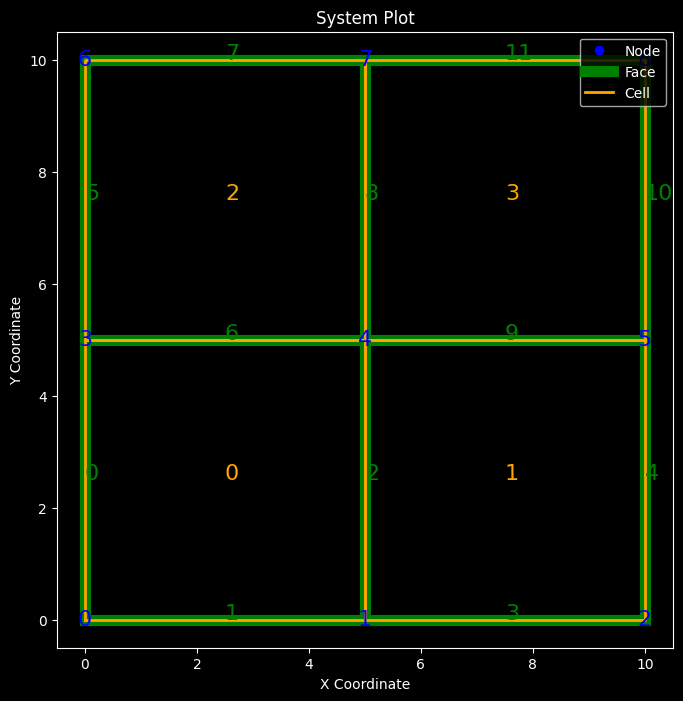

In [47]:
def plot_system(nodes, faces, cells):
    """
    Plot the system defined by nodes, faces, and cells.
    :param nodes: List of Node objects.
    :param faces: List of Face objects.
    :param cells: List of Cell objects.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    fontsize = 16
    colors = {
        "Node": "blue",
        "Face": "green",
        "Cell": "orange"
    }

    # Plot nodes
    for node in nodes:
        x, y = node.coordinates
        ax.plot(x, y, 'o', color=colors["Node"], label="Node" if node.id == 0 else None)
        ax.text(x, y, f'{node.id}', color=colors["Node"], fontsize=fontsize, ha='center', va='center')

    # Plot faces
    for face in faces:
        node_coords = [nodes[node_id].coordinates for node_id in face.nodes]
        x_coords, y_coords = zip(*node_coords)
        ax.plot(x_coords, y_coords, color=colors["Face"], label="Face" if face.id == 0 else None, linewidth=8.0)
        mid_x, mid_y = sum(x_coords) / 2, sum(y_coords) / 2
        ax.text(mid_x, mid_y, f'{face.id}', color=colors["Face"], fontsize=fontsize)

    # Plot cells
    for cell in cells:
        cell_coords = [nodes[node_id].coordinates for node_id in cell.nodes]
        x_coords, y_coords = zip(*cell_coords + [cell_coords[0]])  # Close the polygon
        ax.plot(x_coords, y_coords, color=colors["Cell"], label="Cell" if cell.id == 0 else None, linewidth = 2.0)
        center_x = sum(coord[0] for coord in cell_coords) / len(cell_coords)
        center_y = sum(coord[1] for coord in cell_coords) / len(cell_coords)
        ax.text(center_x, center_y, f'{cell.id}', color=colors["Cell"], fontsize=fontsize)

    # Configure plot
    ax.set_aspect('equal')
    ax.set_title("System Plot")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.legend(loc="upper right", fontsize=10)
    # plt.grid(True)
    plt.show()

# Example usage
plot_system(nodes, faces, cells)

### Creating a mesh

Mesh(
  Nodes: 16,
  Faces: 24,
  Cells: 9
)
Nodes:
Node(id=0, coordinates=(0.0, 0.0), neighbors=[])
Node(id=1, coordinates=(0.3333333333333333, 0.0), neighbors=[])
Node(id=2, coordinates=(0.6666666666666666, 0.0), neighbors=[])
Node(id=3, coordinates=(1.0, 0.0), neighbors=[])
Node(id=4, coordinates=(0.0, 0.3333333333333333), neighbors=[])
Node(id=5, coordinates=(0.3333333333333333, 0.3333333333333333), neighbors=[])
Node(id=6, coordinates=(0.6666666666666666, 0.3333333333333333), neighbors=[])
Node(id=7, coordinates=(1.0, 0.3333333333333333), neighbors=[])
Node(id=8, coordinates=(0.0, 0.6666666666666666), neighbors=[])
Node(id=9, coordinates=(0.3333333333333333, 0.6666666666666666), neighbors=[])
Node(id=10, coordinates=(0.6666666666666666, 0.6666666666666666), neighbors=[])
Node(id=11, coordinates=(1.0, 0.6666666666666666), neighbors=[])
Node(id=12, coordinates=(0.0, 1.0), neighbors=[])
Node(id=13, coordinates=(0.3333333333333333, 1.0), neighbors=[])
Node(id=14, coordinates=(0.666666

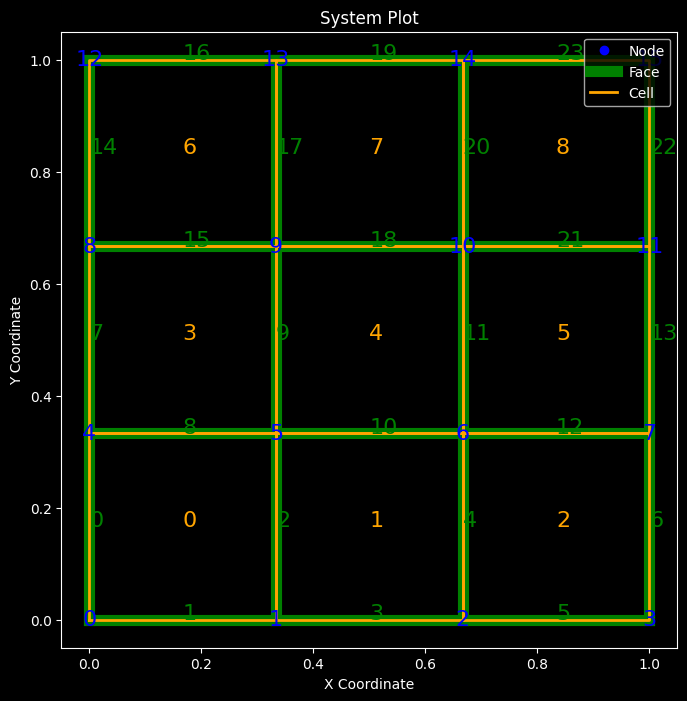

In [50]:
# Example Usage
system_size = (1, 1)  # Width and height of the system
num_cells = (3, 3)  # Number of cells in x and y directions
mesh = Mesh(*create_2d_rectangular_mesh(system_size, num_cells))
print(mesh)
mesh.print_detailed_info()
mesh.plot()

# Numerical solutions to different problems

## 1D Transient Heat Conduction

In [ ]:
# Initialize parameters of the question
k = 50 # Thermal conductivity, W/K
L = 0.1 # m
A = 75e-6 # m^2
cp = 700 # Specific heat capacity, J/(kg * K)
rho = 200 # kg/m^3
# C = cp*rho # J/K, volume specific
alpha = k/(rho*cp) # thermal diffusivity, m^2/s
print(alpha)

# Drichlet boundary conditions
T_L = 390 # K, x=0
T_R = 290 # K, x=L


0.00035714285714285714


In [ ]:
# discretize the space
n_elem = 10
n_nodes = n_elem + 1
l_elem = L/n_elem
dx = l_elem
elem_x = np.linspace(l_elem/2, L-l_elem/2, n_elem)
nodes_x = np.linspace(0, L, n_nodes)
print("Positions of nodes", nodes_x)

n_dof = n_elem # degree of freedom of the system

CON = [] # connectivity
for i in range(n_elem):
    CON.append([i, i+1])
print("Connectivty", CON)

class Element:
    def __init__(self, nodes, x, k, cp, rho, l):
        self.nodes = nodes
        self.x = x
        self.k = k
        self.cp = cp
        self.rho = rho
        self.l = l

    def __repr__(self):
        return f"Element(nodes={self.nodes})"

# create elements
elements = []
for i in range(n_elem):
    x = l_elem*(i+0.5)
    elements.append(Element(CON[i], elem_x[i], k, cp, rho, l_elem))

print("Elements", elements)

Positions of nodes [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
Connectivty [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10]]
Elements [Element(nodes=[0, 1]), Element(nodes=[1, 2]), Element(nodes=[2, 3]), Element(nodes=[3, 4]), Element(nodes=[4, 5]), Element(nodes=[5, 6]), Element(nodes=[6, 7]), Element(nodes=[7, 8]), Element(nodes=[8, 9]), Element(nodes=[9, 10])]


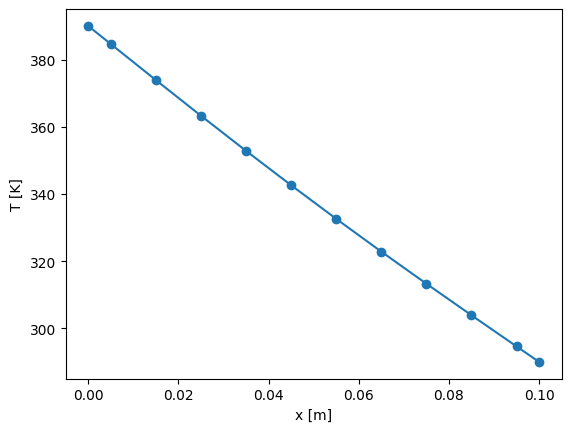

In [ ]:
# discretize the time
t_final = 10
dt = 0.1
t = np.arange(0, t_final, dt)

# creating temperature values
T_0 = 273 # K, initial temperature
T = np.ones(n_dof) * T_0 # for two BC
dTdt = np.zeros(n_dof)

T_log = np.zeros((len(t), n_dof))
T_log[0] = T

plt.figure(1)

for j in range(len(t)):
    for i in range(n_dof):
        element = elements[i]
        alpha = element.k/(element.rho*element.cp)

        if i == 0: # left BC
            dTdt[i] = alpha*(
                -(T[i]-T_L)/(0.5*element.l**2)
                +(T[i+1]-T[i])/element.l**2
                )
        elif i == n_dof-1: # right bC
            dTdt[i] = alpha*(
                (T[i-1]-T[i])/element.l**2
                +(T_R-T[i])/(0.5*element.l**2)
                )
        else:
            dTdt[i] = alpha*(T[i+1]-2*T[i]+T[i-1])/element.l**2
    T = T + dTdt*dt
    T_log[j] = T

    plt.clf()
    plt.plot([0, *elem_x, L], [T_L, *T, T_R], marker="o")
    plt.xlabel("x [m]")
    plt.ylabel("T [K]")
    plt.show()
    display.clear_output(wait=True)


## 2D Steady Heat Conduction (explicit)

In [ ]:
# properties
L = 1 # m
k = 50 # Thermal conductivity, W/K

# domain discretization
n_elem = 20 # in one direction
dx = dy = L/(n_elem+2)
# elem_x = np.linspace(dx/2, L-dx/2, n_elem) # to use this type of mesh, code should chane
# elem_y = np.linspace(dy/2, L-dy/2, n_elem)
elem_x = np.linspace(0, L, n_elem+2)
elem_y = np.linspace(0, L, n_elem+2)

elem_coords = np.array([(x, y) for x in elem_x for y in elem_y])
elem_coords[:5,:]

array([[0.        , 0.        ],
       [0.        , 0.04761905],
       [0.        , 0.0952381 ],
       [0.        , 0.14285714],
       [0.        , 0.19047619]])

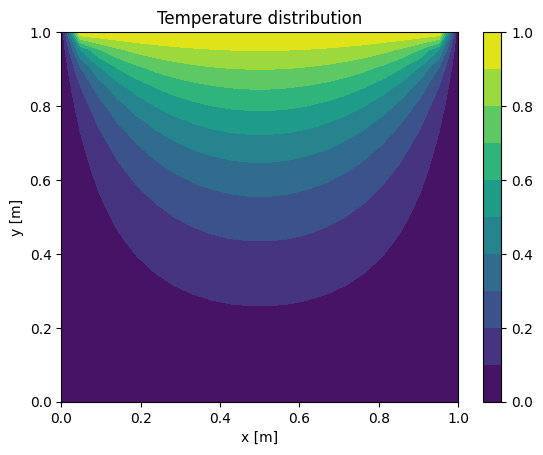

In [ ]:
# temperature values
T = np.zeros((n_elem+2, n_elem+2))
# Drichlet BCs
T[0,:] = 1  # Top
T[-1,:] = 0 # Bottom
T[:,0] = 0  # Left
T[:,-1] = 0 # Right

T_new = T.copy()

tol = 1e-8
numerical_error = 2*tol
while numerical_error > tol:
    for i in range(1,n_elem+1):
        for j in range(1,n_elem+1):
            a_e = k/dx
            a_w = k/dx
            a_s = k/dy
            a_n = k/dy
            a_p = a_e + a_w + a_s + a_n
            T_new[i,j] = (a_e*T[i,j+1] + a_w*T[i,j-1] + a_n*T[i-1,j] + a_s*T[i+1,j])/a_p

    numerical_error = np.max(np.abs(T_new-T))

    T = T_new.copy()


# plot 2d map of temperaturs
X, Y = np.meshgrid(elem_x, L-elem_y)
plt.contourf(X, Y, T, 10)
# plt.pcolormesh(X, Y, T)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.colorbar()
plt.title(f"Temperature distribution")
plt.show()


## 2D Transient Heat Conduction (explicit)

In [ ]:
# properties
L = 0.2 # m
k = 250 # Thermal conductivity, W/K
cp = 900 # Specific heat capacity, J/(kg * K)
rho = 2700 # kg/m^3
alpha = k/(rho*cp) # thermal diffusivity, m^2/s

n_elem = 10 # in one direction
dx = dy = L/(n_elem+2)
# dz = 1
dV = dx*dy
Ae = Aw = dy
An = As = dx

elem_x = np.linspace(0, L, n_elem+2)
elem_y = np.linspace(0, L, n_elem+2)
X, Y = np.meshgrid(elem_x, L-elem_y)


elem_coords = np.array([(x, y) for x in elem_x for y in elem_y])
elem_coords[:5,:]

array([[0.        , 0.        ],
       [0.        , 0.03333333],
       [0.        , 0.06666667],
       [0.        , 0.1       ],
       [0.        , 0.13333333]])

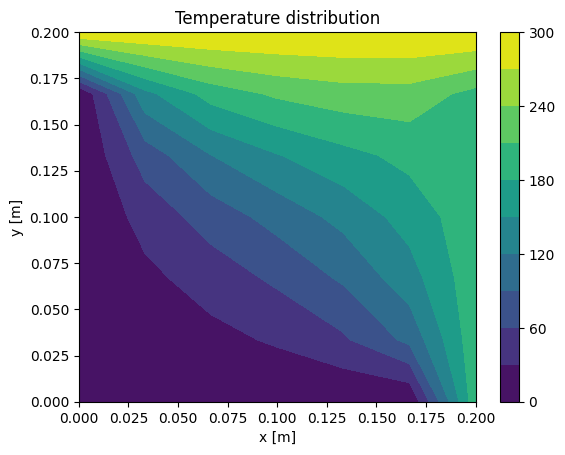

In [ ]:
# temperature values
T = np.zeros((n_elem+2, n_elem+2))
# Drichlet BCs
T[-1,:] = 0 # Bottom
T[:,0] = 0  # Left
T[:,-1] = 200 # Right
T[0,:] = 300  # Top

t_final = 30
dt = 0.1
t = np.arange(0, t_final, dt)

plt.figure(1)
for k in range(len(t)):
    for i in range(1,n_elem+1):
        for j in range(1,n_elem+1):
            T_E = T[i,j-1]
            T_W = T[i,j+1]
            T_N = T[i-1,j]
            T_S = T[i+1,j]
            T_P = T[i,j]

            X_right = alpha*dt*Ae/dV * (T_E-T_P)/dx
            X_left = alpha*dt*Aw/dV * (T_W-T_P)/dx
            Y_up = alpha*dt*An/dV * (T_N-T_P)/dy
            Y_down = alpha*dt*As/dV * (T_S-T_P)/dy

            T[i,j] = T[i,j] + X_right + X_left + Y_up + Y_down

    # plt.pcolormesh(X, Y, T)
    plt.contourf(X, Y, T, 10)
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.colorbar()
    plt.title(f"Temperature distribution")
    plt.show()
    display.clear_output(wait=True)


## Lid-Driven Cavity

In [ ]:
# utils
def central_difference_x(f):
    """Calculates the central difference approximation of the x-derivative of a 2D field."""
    dfdx = (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1)) / (2 * dx)
    # Set boundary values to zero
    dfdx[:, 0] = 0
    dfdx[:, -1] = 0
    dfdx[0, :] = 0
    dfdx[-1, :] = 0
    return dfdx

def central_difference_y(f):
    """Calculates the central difference approximation of the y-derivative of a 2D field."""
    dfdy = (np.roll(f, -1, axis=0) - np.roll(f, 1, axis=0)) / (2 * dy)

    dfdy[:, 0] = 0
    dfdy[:, -1] = 0
    dfdy[0, :] = 0
    dfdy[-1, :] = 0
    return dfdy

def laplace(f):
    """Calculates the Laplacian of a 2D field using central differences."""
    d2fdx2 = (np.roll(f, -1, axis=1) - 2 * f + np.roll(f, 1, axis=1)) / (dx**2)
    d2fdy2 = (np.roll(f, -1, axis=0) - 2 * f + np.roll(f, 1, axis=0)) / (dy**2)
    laplacian_f = d2fdx2 + d2fdy2

    laplacian_f[:, 0] = 0
    laplacian_f[:, -1] = 0
    laplacian_f[0, :] = 0
    laplacian_f[-1, :] = 0

    return laplacian_f


In [ ]:
# properties and constants
nu = 0.1 # kinematic viscosity
rho = 1 # density
L = 1 # meter
n_elem = 50 # in one direction

HORIZONTAL_VELOCITY_TOP = 1
poisson_iterations = 50

dt = 0.001 # seconds
t_final = 1
t = np.arange(0, t_final, dt)

# discrete space
dx = dy = L/(n_elem+2)
l_elem = L/(n_elem+2)
x = np.linspace(0, L, n_elem+2) # extra elements are for boundaries
y = np.linspace(0, L, n_elem+2)
X,Y = np.meshgrid(x, y)

# stability check
max_dt = 0.5*dx*dy/nu
print(dt, max_dt)
if dt < max_dt:
    print("Time step is stable")
else:
    print("Time step is not stable")

0.001 0.001849112426035503
Time step is stable


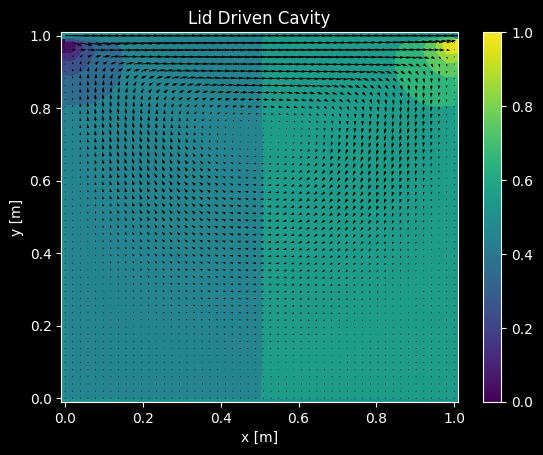

In [ ]:
# fields
u_prev = np.zeros_like(X)
v_prev = np.zeros_like(X)
p_prev = np.zeros_like(X)

plt.figure(1)
for iteration in range(len(t)):
    du_dx = central_difference_x(u_prev)
    du_dy = central_difference_y(u_prev)
    dv_dx = central_difference_x(v_prev)
    dv_dy = central_difference_y(v_prev)
    laplace_u = laplace(u_prev)
    laplace_v = laplace(v_prev)

    # momentum equation without the pressure gradient
    u_tentative = u_prev + dt * (-(u_prev*du_dx + v_prev*du_dy) + nu * laplace_u)
    v_tentative = v_prev + dt * (-(u_prev*dv_dx + v_prev*dv_dy) + nu * laplace_v)

    # velocity drichlet boundary condition
    u_tentative[0, :] = 0.0
    u_tentative[:, 0] = 0.0
    u_tentative[:, -1] = 0.0
    u_tentative[-1, :] = HORIZONTAL_VELOCITY_TOP
    v_tentative[0, :] = 0.0
    v_tentative[:, 0] = 0.0
    v_tentative[:, -1] = 0.0
    v_tentative[-1, :] = 0.0

    # pressure corrections by solving the pressure-poisson equation
    du_dx = central_difference_x(u_tentative)
    dv_dy = central_difference_y(v_tentative)

    rhs = rho/dt * (du_dx + dv_dy)
    for _ in range(poisson_iterations):
        p_next = np.zeros_like(p_prev)
        p_next[1:-1, 1:-1] = 1/4 * (
            p_prev[1:-1, :-2] +
            p_prev[:-2, 1:-1] +
            p_prev[2:, 1:-1] +
            p_prev[1:-1, 2:] -
            dx*dy * rhs[1:-1, 1:-1]
        )
        # pressure neuman boundary conditions, except top (drichlet)
        p_next[:, -1] = p_next[:, -2]
        p_next[0,  :] = p_next[1,  :]
        p_next[:,  0] = p_next[:,  1]
        p_next[-1, :] = 0.0

        p_prev = p_next

    dp_dx = central_difference_x(p_next)
    dp_dy = central_difference_y(p_next)

    # velocity correction
    u_next = (
        u_tentative - dt * (dp_dx / rho)
    )
    v_next = (
        v_tentative - dt * (dp_dy / rho)
    )

    # velocity drichlet boundary condition
    u_next[0, :] = 0.0
    u_next[:, 0] = 0.0
    u_next[:, -1] = 0.0
    u_next[-1, :] = HORIZONTAL_VELOCITY_TOP
    v_next[0, :] = 0.0
    v_next[:, 0] = 0.0
    v_next[:, -1] = 0.0
    v_next[-1, :] = 0.0

    u_prev = u_next
    v_prev = v_next
    p_prev = p_next



plt.pcolormesh(X, Y, p_next)
plt.contourf(X, Y, p_next, 10)
plt.quiver(X, Y, u_next, v_next, color="black")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.colorbar()
plt.title(f"Lid Driven Cavity")
plt.show()
# display.clear_output(wait=True)

